This notebook contains implementation of **Data Analysis/Exploration** ,**Feature Selection** and **Model Training** .

In [1]:
from scipy import stats, integrate
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
import datetime 
import uuid
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(color_codes=True)
pd.options.display.max_rows = 10

In [3]:
# connect to our cluster

from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])


In [4]:
es.indices.put_settings(index="atlas",
                        body= {"index" : {
                                "max_result_window" : 2000000
                              }})

{u'acknowledged': True}

## Loading Data from elasticsearch

In [5]:
# Loading data from Elasticsearch for further usage with pandas.It takes around 50-55 Sec

print "Loading...."
start = time()
types= ["start","end"]
data_start = []
data_end = []
for j in types:
    for i in range(0,10):
        res = es.search(index = "atlas", size=100000,doc_type=j, body={"query": {"match_all": {}}},from_=(i*100000),request_timeout=30)
        if j == "start":
            for hit in res['hits']['hits']:
                data_start.append(hit["_source"])
        else:
            for hit in res['hits']['hits']:
                data_end.append(hit["_source"])
                
print '\ntime taken %s seconds' % str(time() - start)

Loading....

time taken 43.9035589695 seconds


## Loading data to Pandas Dataframes

In [6]:
df_start = pd.DataFrame(data_start)
df_end = pd.DataFrame(data_end)

In [7]:
df_start

,bytes,dst_site,event_type,src_site,timestamp,uuid
0,4.628256e+09,D,transfer-queued,A,2017-03-08 10:00:00,275c597a-2476-4616-bdd0-e73017920987
1,1.998827e+09,B,transfer-queued,A,2017-03-08 10:00:00,ad86b2be-0612-4db7-a2d8-dd07d0ba6a4d
2,5.404987e+09,B,transfer-queued,A,2017-03-08 10:00:00,26dd2e17-75f3-430d-83de-a484c966bb0f
3,7.609555e+09,C,transfer-queued,B,2017-03-08 10:00:00,f59d760e-647f-4261-845f-6a43846ba16e
4,4.683886e+09,E,transfer-queued,A,2017-03-08 10:00:00,240a2305-501d-401d-8526-89fa2874661d
...,...,...,...,...,...,...
999995,1.791897e+09,A,transfer-queued,D,2017-03-08 10:00:00,35f098e3-0cab-48a3-8c4d-67cade829f4b
999996,4.982574e+09,B,transfer-queued,E,2017-03-08 10:00:00,5ac20d43-a237-4482-bc55-eb35f479cbfe
999997,1.896472e+09,B,transfer-queued,C,2017-03-08 10:00:00,a5613c0b-b872-4a81-b484-09340726ce2e
999998,1.617743e+09,D,transfer-queued,B,2017-03-08 10:00:00,31039119-d8d7-4bc8-b250-f298bdfb46d9


In [8]:
df_end

,bytes,dst_site,event_type,src_site,timestamp,uuid
0,2.113857e+09,C,transfer_success,D,2017-03-08 10:03:21.593124,31a846c9-9ba0-45b7-825a-247b5a6d70c1
1,5.114972e+09,B,transfer_success,A,2017-03-08 10:08:07.801724,0657cf64-28f7-49ce-8554-6eb7f032787c
2,8.065796e+09,D,transfer_success,A,2017-03-08 10:12:49.214290,a55b6c74-a8bb-4c5a-825e-bf44191be894
3,5.055894e+09,B,transfer_success,A,2017-03-08 10:08:02.167663,f757a4dd-3e16-4355-a3dc-2ade43ba5790
4,4.990026e+09,C,transfer_success,A,2017-03-08 10:07:55.885942,ce6fc00c-ee54-4491-8487-0189ca47456d
...,...,...,...,...,...,...
999995,1.791897e+09,A,transfer-failed,D,2017-03-08 10:02:50.888589,35f098e3-0cab-48a3-8c4d-67cade829f4b
999996,4.982574e+09,B,transfer-failed,E,2017-03-08 10:07:55.175247,5ac20d43-a237-4482-bc55-eb35f479cbfe
999997,1.896472e+09,B,transfer-failed,C,2017-03-08 10:03:00.861620,a5613c0b-b872-4a81-b484-09340726ce2e
999998,1.617743e+09,D,transfer-failed,B,2017-03-08 10:02:34.280043,31039119-d8d7-4bc8-b250-f298bdfb46d9


In [42]:
# The two sets are merged on the on UUID common key

df_final = pd.merge(df_end,df_start[["uuid","timestamp"]],on="uuid")
df_final

,bytes,dst_site,event_type,src_site,timestamp_x,uuid,timestamp_y
0,2.113857e+09,C,transfer_success,D,2017-03-08 10:03:21.593124,31a846c9-9ba0-45b7-825a-247b5a6d70c1,2017-03-08 10:00:00
1,5.114972e+09,B,transfer_success,A,2017-03-08 10:08:07.801724,0657cf64-28f7-49ce-8554-6eb7f032787c,2017-03-08 10:00:00
2,8.065796e+09,D,transfer_success,A,2017-03-08 10:12:49.214290,a55b6c74-a8bb-4c5a-825e-bf44191be894,2017-03-08 10:00:00
3,5.055894e+09,B,transfer_success,A,2017-03-08 10:08:02.167663,f757a4dd-3e16-4355-a3dc-2ade43ba5790,2017-03-08 10:00:00
4,4.990026e+09,C,transfer_success,A,2017-03-08 10:07:55.885942,ce6fc00c-ee54-4491-8487-0189ca47456d,2017-03-08 10:00:00
...,...,...,...,...,...,...,...
999995,1.791897e+09,A,transfer-failed,D,2017-03-08 10:02:50.888589,35f098e3-0cab-48a3-8c4d-67cade829f4b,2017-03-08 10:00:00
999996,4.982574e+09,B,transfer-failed,E,2017-03-08 10:07:55.175247,5ac20d43-a237-4482-bc55-eb35f479cbfe,2017-03-08 10:00:00
999997,1.896472e+09,B,transfer-failed,C,2017-03-08 10:03:00.861620,a5613c0b-b872-4a81-b484-09340726ce2e,2017-03-08 10:00:00
999998,1.617743e+09,D,transfer-failed,B,2017-03-08 10:02:34.280043,31039119-d8d7-4bc8-b250-f298bdfb46d9,2017-03-08 10:00:00


### The Transfer duration is calculated from the above data and stored

In [43]:
df_final["timestamp_x"] = pd.to_datetime(df_final["timestamp_x"])
df_final["timestamp_y"] = pd.to_datetime(df_final["timestamp_y"])

df_final["timestamp"] = df_final["timestamp_x"] - df_final["timestamp_y"]
df_final = df_final.drop(["timestamp_x","timestamp_y"],axis=1)

In [44]:
df_final["timestamp"] = df_final["timestamp"].dt.total_seconds()

In [45]:
df_final

,bytes,dst_site,event_type,src_site,uuid,timestamp
0,2.113857e+09,C,transfer_success,D,31a846c9-9ba0-45b7-825a-247b5a6d70c1,201.593124
1,5.114972e+09,B,transfer_success,A,0657cf64-28f7-49ce-8554-6eb7f032787c,487.801724
2,8.065796e+09,D,transfer_success,A,a55b6c74-a8bb-4c5a-825e-bf44191be894,769.214290
3,5.055894e+09,B,transfer_success,A,f757a4dd-3e16-4355-a3dc-2ade43ba5790,482.167663
4,4.990026e+09,C,transfer_success,A,ce6fc00c-ee54-4491-8487-0189ca47456d,475.885942
...,...,...,...,...,...,...
999995,1.791897e+09,A,transfer-failed,D,35f098e3-0cab-48a3-8c4d-67cade829f4b,170.888589
999996,4.982574e+09,B,transfer-failed,E,5ac20d43-a237-4482-bc55-eb35f479cbfe,475.175247
999997,1.896472e+09,B,transfer-failed,C,a5613c0b-b872-4a81-b484-09340726ce2e,180.861620
999998,1.617743e+09,D,transfer-failed,B,31039119-d8d7-4bc8-b250-f298bdfb46d9,154.280043


In [46]:
# The dataframe can be stored in CSV format for future processing wth data instead of loading the whole data every time

# df_final.to_csv("final.csv",header=True,index = False)

In [47]:
# df_final = pd.read_csv("final.csv")

# Data Analysis ,Exploration and Visualization

## Univariate Data Analysis

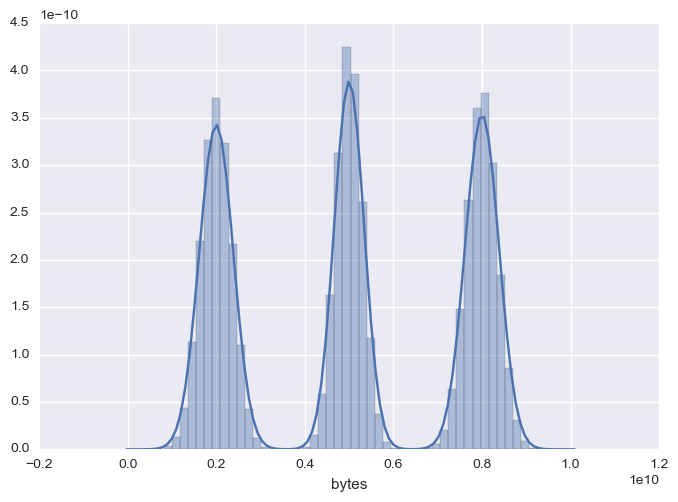

In [39]:
sns.distplot(df_final["bytes"]);
plt.show()

**The above plot shows a Gaussian distribution of #bytes transferred.**

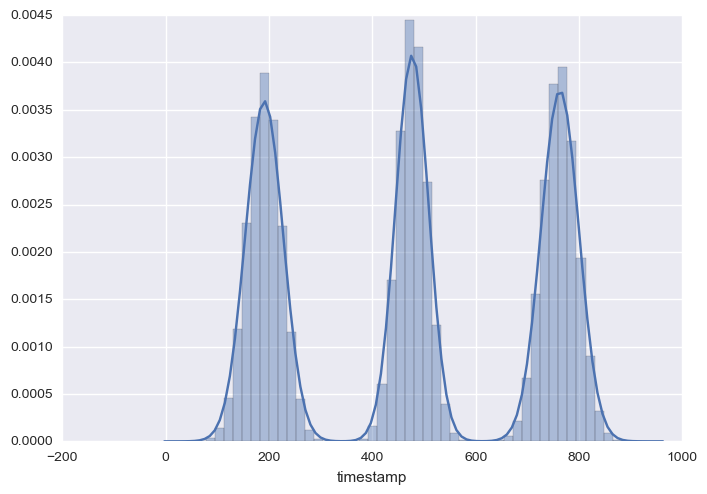

In [40]:
sns.distplot(df_final["timestamp"]);
plt.show()

**The above plot shows a distribution of Transfer Duration**

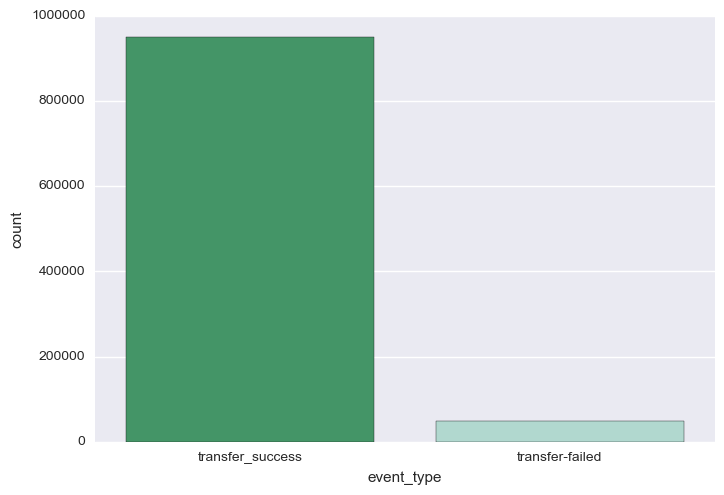

In [48]:
sns.countplot(x="event_type", data=df_final, palette="BuGn_r");
plt.show()

**The graph shows different final event type distribution.**

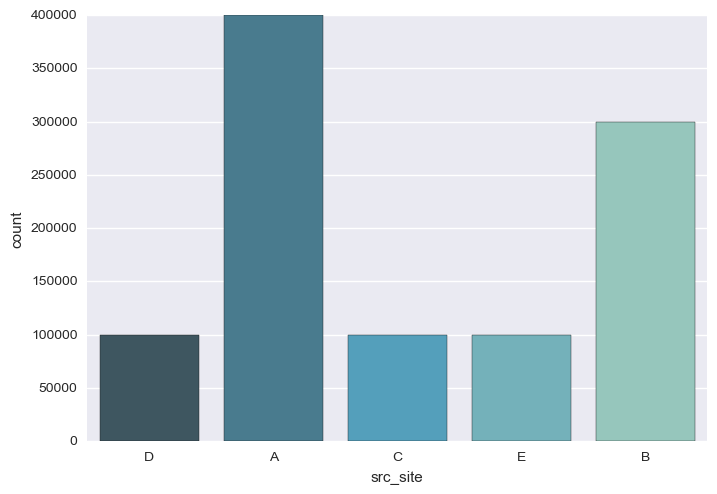

In [49]:
sns.countplot(x="src_site", data=df_final, palette="GnBu_d");
plt.show()

**The above graph frquency distribution across different source sites.**

## Bivariate Data Analysis

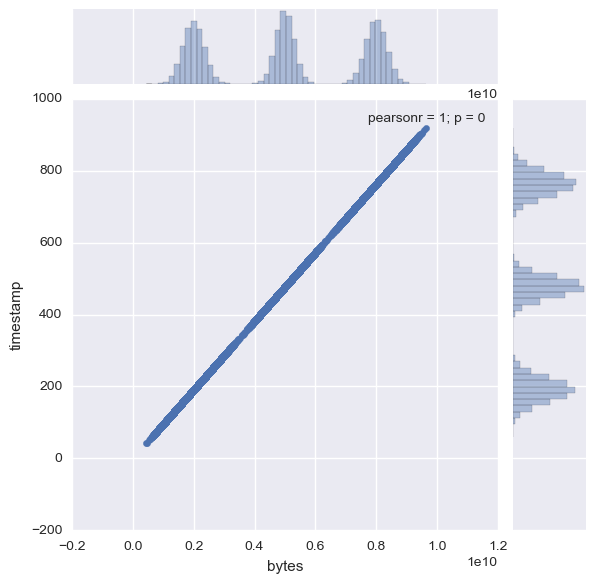

In [50]:
sns.jointplot(x="bytes", y="timestamp", data=df_final);
plt.show()

**The above plot show the linear relationship between Time duration and bytes with Pearson correlation coefficient  =1**

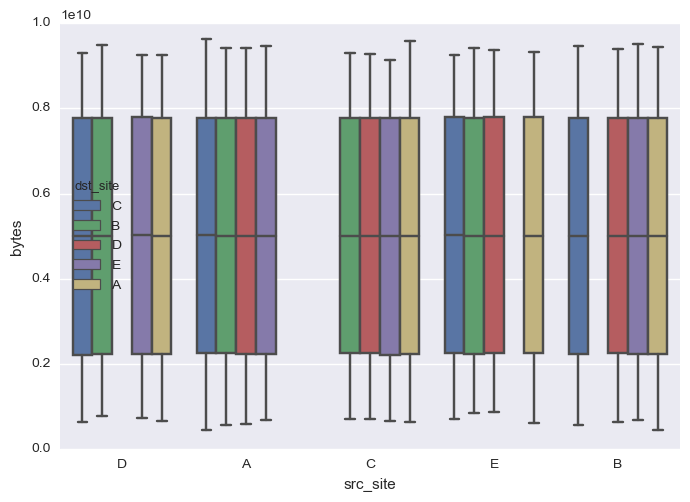

In [52]:
sns.boxplot(x="src_site", y="bytes",hue="dst_site",data=df_final);
plt.show()

**The above plot shows the Transfer duration distribution for data(#Bytes) throughput between every pair of site.**

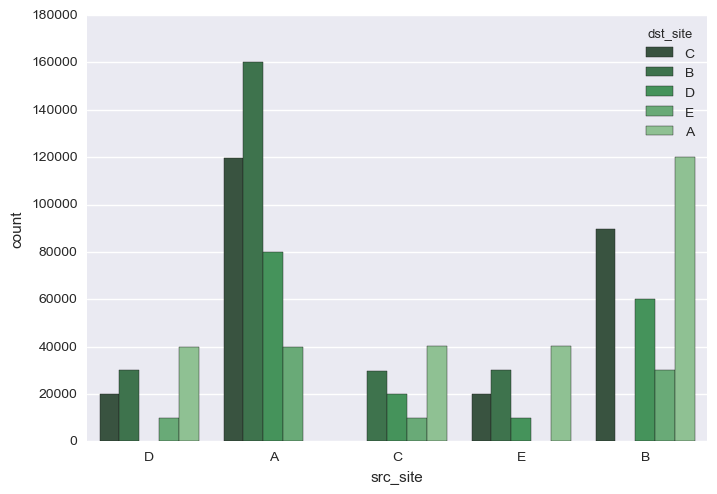

In [53]:
sns.countplot(x="src_site", data=df_final,hue="dst_site", palette="Greens_d");
plt.show()

**The above plot shows the count(frequency)of number of files throughput between Source and destination sites.**

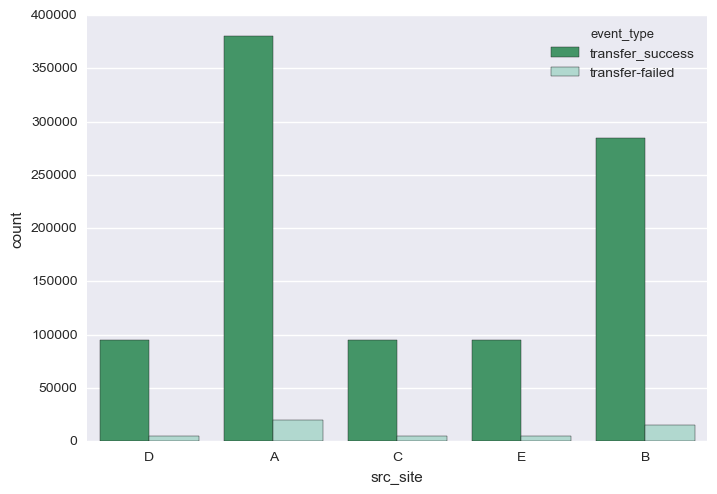

In [54]:
sns.countplot(x="src_site", data=df_final,hue="event_type", palette="BuGn_r");
plt.show()

**The above plot shows the count(frequency)of number of files throughput by source for different event types.**

### Coversion of categorical text data to numeric form.

In [55]:
df_final['dst_site'] = df_final['dst_site'].astype('category')
print df_final["dst_site"].cat.categories
df_final['src_site'] = df_final['src_site'].astype('category')
print df_final["src_site"].cat.categories
df_final['event_type'] = df_final['event_type'].astype('category')
print df_final["event_type"].cat.categories

Index([u'A', u'B', u'C', u'D', u'E'], dtype='object')
Index([u'A', u'B', u'C', u'D', u'E'], dtype='object')
Index([u'transfer-failed', u'transfer_success'], dtype='object')


In [56]:
cat_columns = df_final.select_dtypes(['category']).columns

In [57]:
df_final[cat_columns] = df_final[cat_columns].apply(lambda x: x.cat.codes)

In [58]:
df_final

,bytes,dst_site,event_type,src_site,uuid,timestamp
0,2.113857e+09,2,1,3,31a846c9-9ba0-45b7-825a-247b5a6d70c1,201.593124
1,5.114972e+09,1,1,0,0657cf64-28f7-49ce-8554-6eb7f032787c,487.801724
2,8.065796e+09,3,1,0,a55b6c74-a8bb-4c5a-825e-bf44191be894,769.214290
3,5.055894e+09,1,1,0,f757a4dd-3e16-4355-a3dc-2ade43ba5790,482.167663
4,4.990026e+09,2,1,0,ce6fc00c-ee54-4491-8487-0189ca47456d,475.885942
...,...,...,...,...,...,...
999995,1.791897e+09,0,0,3,35f098e3-0cab-48a3-8c4d-67cade829f4b,170.888589
999996,4.982574e+09,1,0,4,5ac20d43-a237-4482-bc55-eb35f479cbfe,475.175247
999997,1.896472e+09,1,0,2,a5613c0b-b872-4a81-b484-09340726ce2e,180.861620
999998,1.617743e+09,3,0,1,31039119-d8d7-4bc8-b250-f298bdfb46d9,154.280043


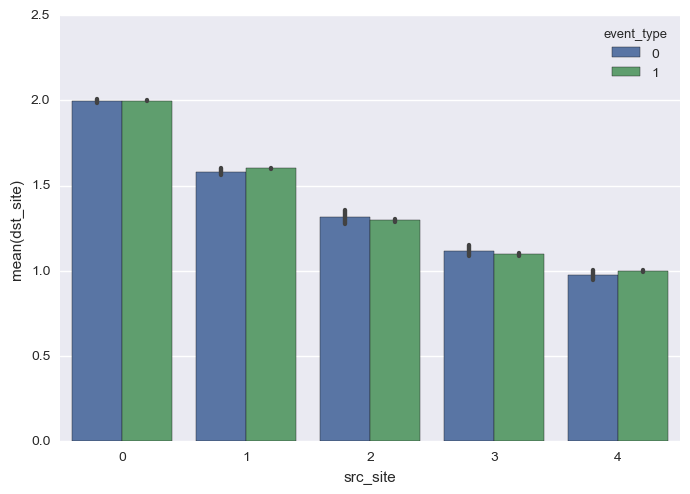

In [59]:
sns.barplot(x="src_site", y="dst_site",hue="event_type", data=df_final);
plt.show()

## Feature Selection

**This is one of the important step in a ML pipeline.The Filter method technique was used for this.**

**Visualize_ML(https://github.com/ayush1997/visualize_ML) is a Self made Python Package used for steps like Data Analysis and feature selection(filter method.)
PLease install package and uncomment the below code in case you want to test and produce the result though I have uploaded the results below.**

In [60]:
# from visualize_ML import relation

# relation.plot(df_final,"timestamp",["event_type","dst_site","src_site"],drop=["uuid"],bin_size=10)

In [61]:
import os
from IPython.display import display, Image

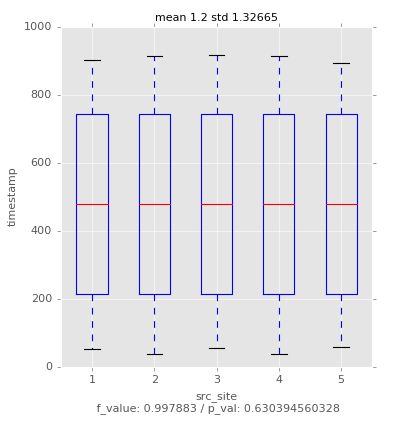

In [62]:
# src_site vs timestamp(transfer duration)

display(Image('src.png', width=300))

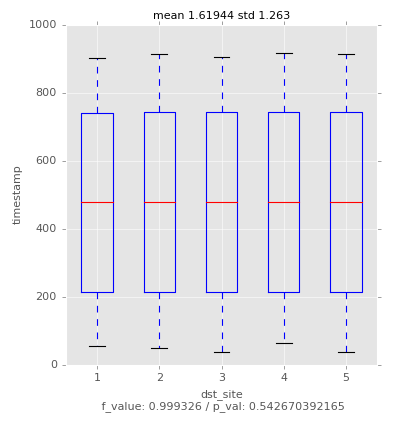

In [63]:
# dst_site vs timestamp(transfer duration)

display(Image('dst.png', width=300))

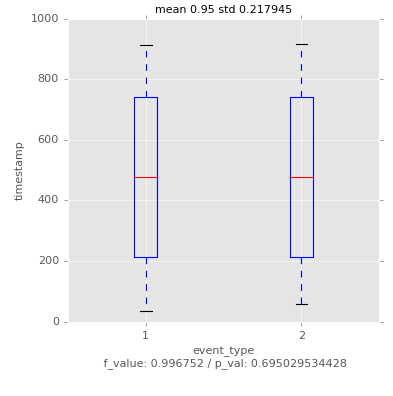

In [64]:
# event_type vs timestamp(transfer duration)

display(Image('event.png', width=300))

**From the analysis and filter method consideration the P_VALUES for categorical features SRC_SITE,DST_SITE and EVENT_TYPE were found to be > 0.05 showing least dependence of Target variable(Transfer Duration ) with these variables.
Whereas the Pearson correlation for continous variable #BYTES was found to be 1 showing its direct positive relation with the Transfer rate.Therefore #Bytes was taken as the only trainig variable for this task**
**The model was trained on other 3 variables as well and as expected gave less accuracy than this.**

### Some Data processing
**Converting the categorical parameters to One-Hot encoded dummies form.**

In [65]:
y = pd.get_dummies(df_final['event_type'],prefix="event")
df_final = pd.concat([df_final,y],axis=1)
y = pd.get_dummies(df_final['src_site'],prefix="src")
df_final = pd.concat([df_final,y],axis=1)
y = pd.get_dummies(df_final['dst_site'],prefix="dst")
df_final = pd.concat([df_final,y],axis=1)

In [66]:
df_final

,bytes,dst_site,event_type,src_site,uuid,timestamp,event_0,event_1,src_0,src_1,src_2,src_3,src_4,dst_0,dst_1,dst_2,dst_3,dst_4
0,2.113857e+09,2,1,3,31a846c9-9ba0-45b7-825a-247b5a6d70c1,201.593124,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5.114972e+09,1,1,0,0657cf64-28f7-49ce-8554-6eb7f032787c,487.801724,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,8.065796e+09,3,1,0,a55b6c74-a8bb-4c5a-825e-bf44191be894,769.214290,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5.055894e+09,1,1,0,f757a4dd-3e16-4355-a3dc-2ade43ba5790,482.167663,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.990026e+09,2,1,0,ce6fc00c-ee54-4491-8487-0189ca47456d,475.885942,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.791897e+09,0,0,3,35f098e3-0cab-48a3-8c4d-67cade829f4b,170.888589,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
999996,4.982574e+09,1,0,4,5ac20d43-a237-4482-bc55-eb35f479cbfe,475.175247,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
999997,1.896472e+09,1,0,2,a5613c0b-b872-4a81-b484-09340726ce2e,180.861620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
999998,1.617743e+09,3,0,1,31039119-d8d7-4bc8-b250-f298bdfb46d9,154.280043,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [67]:
# Dropping the fields not needed further

df_final = df_final.drop(["dst_site","event_type","src_site","uuid"],axis=1)

In [68]:
df_final

,bytes,timestamp,event_0,event_1,src_0,src_1,src_2,src_3,src_4,dst_0,dst_1,dst_2,dst_3,dst_4
0,2.113857e+09,201.593124,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5.114972e+09,487.801724,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,8.065796e+09,769.214290,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5.055894e+09,482.167663,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.990026e+09,475.885942,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.791897e+09,170.888589,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
999996,4.982574e+09,475.175247,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
999997,1.896472e+09,180.861620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
999998,1.617743e+09,154.280043,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Training Neural Network Model on the Data

**Training a simple 1 hidden layered(with 10 neurons) Neural Network with RELU activation function and ADAM optimizer for this regression task.**

In [69]:
# Making Training and Testing Data

X_train = df_final.drop(["timestamp"],axis=1)["bytes"]
Y_train = df_final["timestamp"]

In [70]:
# Scaling the training and testing dataset.

scaler1 = StandardScaler()
X_train = scaler1.fit_transform(X_train)

scaler2 = StandardScaler()
Y_train = scaler2.fit_transform(Y_train)

/home/ayush/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ayush/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ayush/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has 

In [71]:
df_scaled = pd.DataFrame(X_train)
df_scaled.columns = ["bytes"]

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Activation


Using TensorFlow backend.


In [73]:
# The trainig takes around 25-26Mins for 10 epochs (will vary on different machines.)

start = time()

model = Sequential()
model.add(Dense(10, input_dim=1, init='normal', activation='relu'))
model.add(Dense(1, init='normal'))

# "mean_squared_error" was taken as the loss function with "mean_absolute_percentage_error" as the evaluation metrics.

model.compile(loss='mean_squared_error', optimizer='adam')

# The Dataset was divided into 2 sets one for Trainig and other for Testing with 80:20 ratio.The 20% is testing data which is unseen and not used in traing

hist = model.fit(np.array(df_scaled["bytes"][:800000]), Y_train[:800000],validation_data=(np.array(df_scaled["bytes"][800000:]),Y_train[800000:]),batch_size=1000)

print '\ntime taken %s seconds' % str(time() - start)

Train on 800000 samples, validate on 200000 samples
Epoch 1/10
800000/800000 [==============================] - 20s - loss: 0.2261 - val_loss: 0.0025
Epoch 2/10
800000/800000 [==============================] - 7s - loss: 0.0024 - val_loss: 0.0020
Epoch 3/10
800000/800000 [==============================] - 7s - loss: 0.0015 - val_loss: 0.0011
Epoch 4/10
800000/800000 [==============================] - 7s - loss: 7.5135e-04 - val_loss: 4.1879e-04
Epoch 5/10
800000/800000 [==============================] - 8s - loss: 3.7930e-04 - val_loss: 3.4840e-04
Epoch 6/10
800000/800000 [==============================] - 7s - loss: 3.1795e-04 - val_loss: 2.8819e-04
Epoch 7/10
800000/800000 [==============================] - 6s - loss: 2.5705e-04 - val_loss: 2.2731e-04
Epoch 8/10
800000/800000 [==============================] - 8s - loss: 1.9679e-04 - val_loss: 1.6760e-04
Epoch 9/10
800000/800000 [==============================] - 8s - loss: 1.4030e-04 - val_loss: 1.1451e-04
Epoch 10/10
800000/800000 

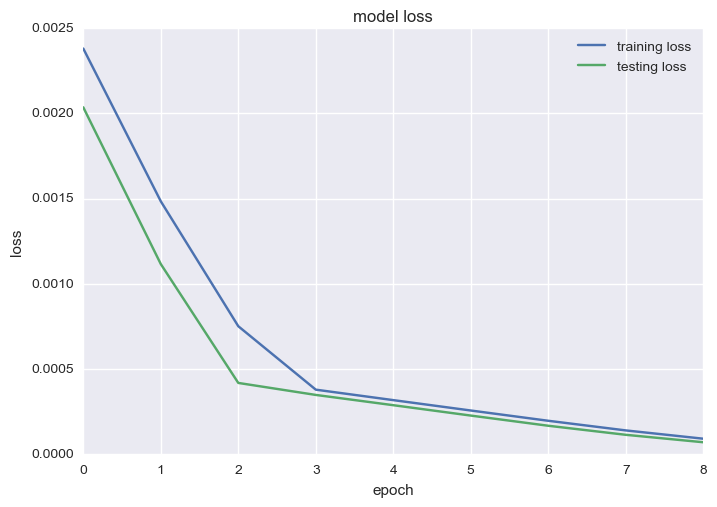

In [74]:
# summarize history for loss
# To displat the graph in scale the first reading is excluded
plt.plot(hist.history['loss'][1:])
plt.plot(hist.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'testing loss'], loc='upper right')
plt.show()

### Describe in words why and how this approximates the original random generator 

Neural network is a machine learning approach which are know for their low level feature abstraction.They comprise of layers which contain neurons in them which are inteconnected and have a weight associated with each connection.Activation layers like softmax,RELU etc help in bringing the non-linearilty and gives it the ability to fit non linear data.Through backpropagation it is able to propagate back through every neuron and optimize the weights associated with it.  

When dealing with a regression problem our aim is to find the best fit line through a n-dimentional space(n features).It greaty depends on the shape on the data distribution(linear or non linear) between all features and target variable.

In our case the feature(#Bytes) is highy correlated with the target variable which can be seen through the value of Pearson correlation(i.e 1).Moreover it was only 1 dimentional so the neural network didnt have much problem to learn the linear pattern and give very high accuracy/low error.